In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import healpy as hp
pi=n.pi
c=299792458.

In [2]:
fList=n.arange(50,210,10)

In [3]:
#rotate
def rotateBeam(inputMap,rot=[90,0,0]):
    rotator=hp.Rotator(rot=rot)
    npix=len(inputMap)
    nside=hp.npix2nside(npix)
    theta,phi=hp.pix2ang(nside,range(npix))
    newtheta,newphi=rotator(theta,phi)
    output=hp.get_interp_val(inputMap,newtheta,newphi)
    return output
    


class Beam:
    def __init__(self,dirName,fList,nside,pols=['XX','YY'],rotateY=False):
        self.nf=len(fList)
        self.fAxis=n.zeros(self.nf)
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.pixArea=hp.nside2pixarea(self.nSide)
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.round(n.degrees(theta)).astype(int)
        phi=n.round(n.degrees(phi)).astype(int)
        self.data=n.zeros((self.npols,self.nf,self.nPix))
        if(rotateY):
            pols.append('YY')
        self.pols=pols
        for m in range(self.nf):
            print m
            tempf=fList[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            if(len(tempf)>1):
                self.fAxis[m]+=float(tempf[1])/10.**(len(tempf[1]))*1e6
            for np in range(self.npolsOriginal):
                data=n.loadtxt('../data/beams/%s/%s_%s_%s.txt'%(dirName,dirName,fList[m],self.pols[np]),skiprows=2);
                self.data[np,m,:]=10**((data[:,2].squeeze().reshape(360,181))[phi,theta]/10.)
                self.data[np,m,:]/=self.data[np,m,:].flatten().max(); 
                self.data[np,m,theta>90.]=0.
                self.solidAngles[np,m]=self.pixArea*n.sum(self.data[np,m,:])
                self.effArea[np,m]=(c/(self.fAxis[m]))**2./self.solidAngles[np,m]
            if(self.npolsOriginal==1):
                self.data[1,m,:]=rotateBeam(self.data[0,m,:].flatten())
                self.solidAngles[1,m]=self.pixArea*n.sum(self.data[1,m,:])
                self.effArea[1,m]=(c/(self.fAxis[m]))**2./self.solidAngles[1,m]
            if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
                self.ellipticity[m]=n.sum((self.data[0,m]-self.data[1,m])**2.)/n.sum((self.data[0,m]+self.data[1,m])**2.)
                


In [4]:
#beamCylinder=Beam('beamCylinder',['100'],64)
fstrList=['050','060','070','080','090','100','110','120','130','140','150']
beamCylinder=Beam('beamCylinderBackPlane',fstrList,64,['XX'],rotateY=True)
beamNoCylinder=Beam('beamBackPlane',fstrList,64,['XX'],rotateY=True)
beamBareDipole=Beam('beamBareDipole',fstrList,64,['XX'],rotateY=True)
beamPaneledCylinder=Beam('beamPaneledCylinder',fstrList,64,['XX'],rotateY=True)
beamCylinderV2=Beam('beamCylinderBackPlane_v2',fstrList,64,['XX'],rotateY=True)





0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10


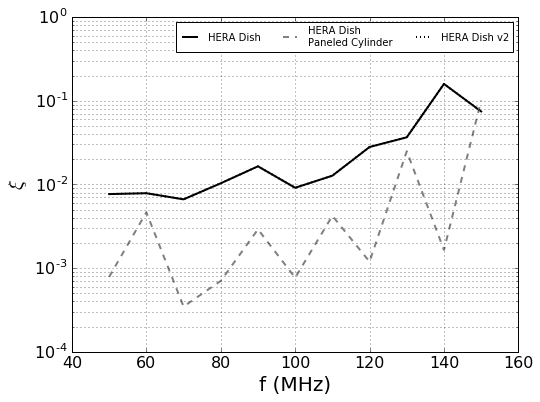

In [14]:
p.plot(beamCylinder.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish',color='k',ls='-',lw=2)
#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('$\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/compareEllipticity.pdf',bbox_inches='tight')

[ 28.42877679]
[ 35.42846166]


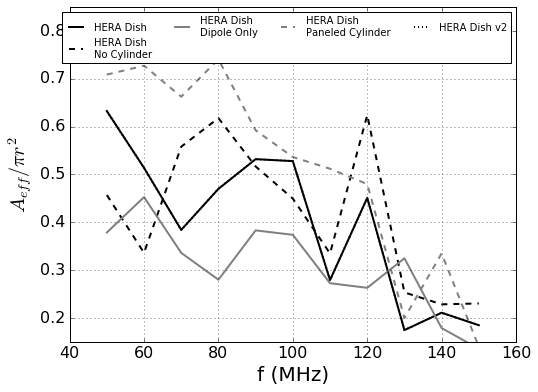

In [16]:
p.plot(beamCylinder.fAxis/1e6,beamCylinder.effArea[0]/(pi*7*7),label='HERA Dish',color='k',ls='-',lw=2)
print beamCylinder.effArea[0][beamCylinder.fAxis==150e6]
p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.effArea[0]/(pi*7*7),label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
print beamNoCylinder.effArea[0][beamNoCylinder.fAxis==150e6]
#p.plot(beamNoBackPlane.fAxis/1e6,beamNoBackPlane.effAreaXX/(pi*7*7),label='No BackPlane')
p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.effArea[0]/(pi*7*7),label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.effArea[0]/(pi*7*7),label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.effArea[0]/(pi*7*7),label='HERA Dish v2',color='k',ls=':',lw=2)



#print beamBareDipole.effArea[0][beamBareDipole.fAxis==150e6]
p.xlabel('f (MHz)',fontsize=20)
p.ylabel('$A_{eff}/\\pi r^2$',fontsize=20)
p.grid()
p.ylim(.15,.85)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
#p.gca().yaxis.grid(which='minor')
p.legend(loc='best',fontsize=10,ncol=4)
#p.savefig('../analysis/Percentage_illumination.pdf')

In [7]:
#take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=data[hp.ang2pix(nSide,thetaVals,phiVals)]
    return output
    

/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


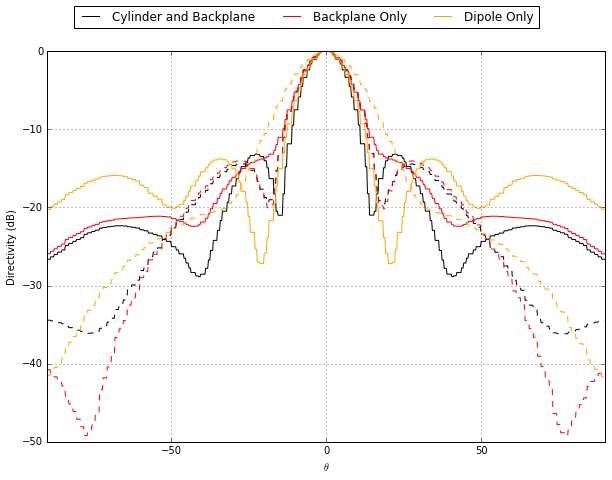

In [8]:
nth=800
tha=n.degrees(n.arange(-nth/2,nth/2)*pi/nth)
p.plot(tha,hpCut(0,nth,10*n.log10(beamCylinder.data[0,5,:])),color='k',ls='--')
l1=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamCylinder.data[0,5,:])),color='k')[0]


p.plot(tha,hpCut(0,nth,10*n.log10(beamNoCylinder.data[0,5,:])),color='r',ls='--')
l2=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamNoCylinder.data[0,5,:])),color='r')[0]

#p.plot(tha,hpCut(0,nth,10*n.log10(beamNoBackPlane.dataXX[5,:])),color='b',ls='--')
#l3=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamNoBackPlane.dataXX[5,:])),color='b')[0]


p.plot(tha,hpCut(0,nth,10*n.log10(beamBareDipole.data[0,5,:])),color='orange',ls='--')
l3=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamBareDipole.data[0,5,:])),color='orange')[0]

p.gcf().legend((l1,l2,l3),('Cylinder and Backplane','Backplane Only','Dipole Only'),loc='upper center',ncol=3)
p.grid()
p.xlabel('$\\theta$')
p.xlim(-90,90)
p.ylim(-50,0)
p.ylabel('Directivity (dB)')
p.gcf().set_size_inches([10,7])

/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


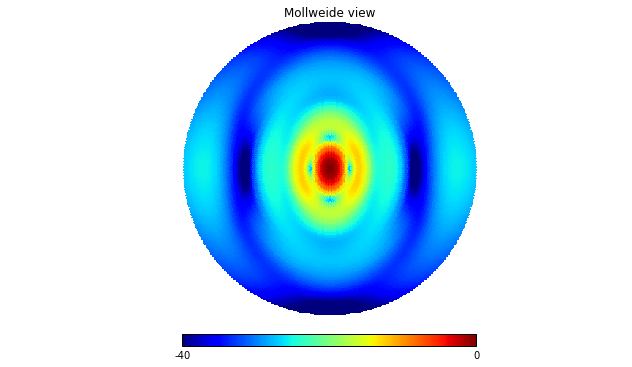

In [9]:
for m in range(7,8):
    hp.mollview(10*n.log10(beamNoCylinder.data[0,m,:]),rot=(0,90,0),min=-40,max=0)

/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


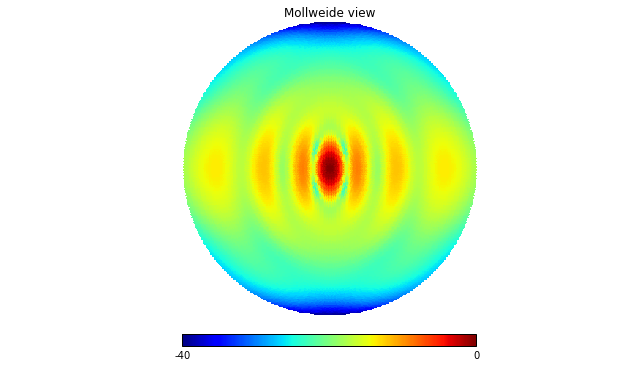

In [10]:
for m in range(7,8):
    hp.mollview(10*n.log10(beamBareDipole.data[0,m,:]),rot=(0,90,0),min=-40,max=0)